# BirdCLEF CNN on Mel Spectrograms (From Scratch)

This notebook trains a CNN model from scratch on mel spectrograms for the BirdCLEF 2025 competition, based on successful approaches from music genre classification.

In [1]:
# Install required packages for Google Colab
!pip install -q librosa scikit-image torchsummary gdown

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import gdown

# Set seeds for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed()

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Loading and Configuration

Define paths and constants for the dataset

In [4]:
# Define paths
DATA_PATH = '/content/drive/MyDrive/birdclef-2025-data'
MODEL_SAVE_DIR = '/content/drive/MyDrive/birdclef-2025-models'
AUDIO_DIR = os.path.join(DATA_PATH, 'train_audio')
TRAIN_CSV = os.path.join(DATA_PATH, 'train.csv')
MODEL_SAVE_PATH = os.path.join(MODEL_SAVE_DIR, 'bird_cnn_scratch.pt')

# Create model save directory if it doesn't exist
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)

# Verify paths
print(f"Data path exists: {os.path.exists(DATA_PATH)}")
print(f"Model save directory: {MODEL_SAVE_DIR}")

# Load the metadata
train_df = pd.read_csv(TRAIN_CSV)
print(f"Training data shape: {train_df.shape}")
print(f"Unique species: {train_df['primary_label'].nunique()}")
train_df.head()

Data path exists: True
Model save directory: /content/drive/MyDrive/birdclef-2025-models
Training data shape: (28564, 13)
Unique species: 206


,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0


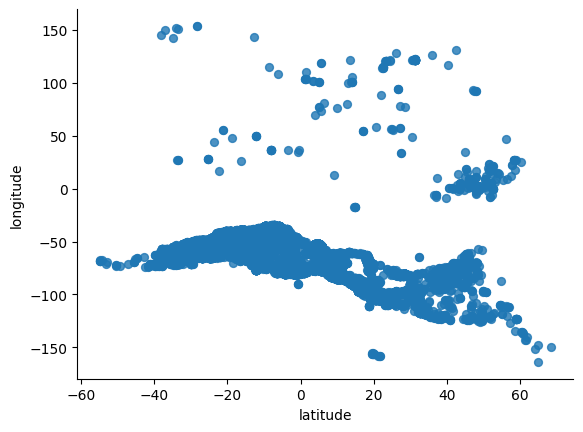

In [20]:
# @title latitude vs longitude

from matplotlib import pyplot as plt
train_df.plot(kind='scatter', x='latitude', y='longitude', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

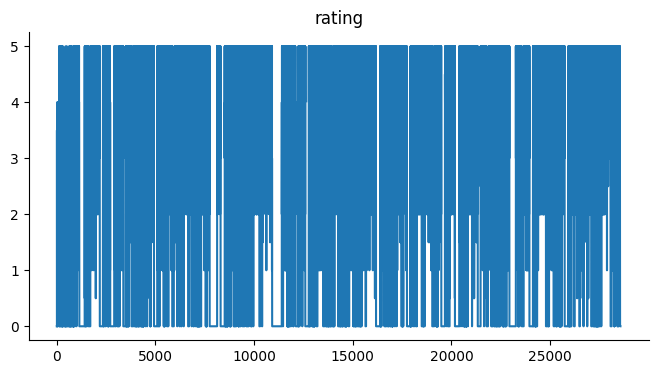

In [19]:
# @title rating

from matplotlib import pyplot as plt
train_df['rating'].plot(kind='line', figsize=(8, 4), title='rating')
plt.gca().spines[['top', 'right']].set_visible(False)

## Using Precomputed Features

Load precomputed mel spectrograms from a shared Google Drive link to skip the time-consuming feature extraction process.

In [5]:
# URL for the shared Google Drive file (no longer needed)
# PRECOMPUTED_FEATURES_URL = "https://drive.google.com/file/d/1bkkglM6lV1aV-9bSsVpD475YewPwblmL/view?usp=sharing"
# Use the local copy from your Google Drive instead
PRECOMPUTED_FEATURES_PATH = "/content/drive/MyDrive/bird_features_scratch_copy.npz"

def load_precomputed_features(local_path=PRECOMPUTED_FEATURES_PATH):
    """Load precomputed features from Google Drive."""
    # Check if file exists
    if not os.path.exists(local_path):
        print(f"ERROR: Precomputed features file not found at {local_path}")
        return None, None

    # Load the features
    print(f"Loading precomputed features from {local_path}...")
    try:
        data = np.load(local_path)
        X = data['data']
        y = data['labels']
        print(f"Successfully loaded precomputed features!")
        print(f"Features shape: {X.shape}")
        print(f"Labels shape: {y.shape}")
        print(f"Number of unique classes: {len(np.unique(y))}")
        return X, y
    except Exception as e:
        print(f"Error loading precomputed features: {e}")
        return None, None

# Load the precomputed features
X, y = load_precomputed_features()

Loading precomputed features from /content/drive/MyDrive/bird_features_scratch_copy.npz...
Successfully loaded precomputed features!
Features shape: (190153, 1, 128, 256)
Labels shape: (190153,)
Number of unique classes: 206


## Data Preparation

Prepare the dataset for training by handling classes with only one sample and splitting into train/validation sets.

In [6]:
# Count occurrences of each label
label_counts = np.bincount(y)
print(f"Number of classes with only one sample: {np.sum(label_counts == 1)}")

# Handle classes with only one sample
if np.any(label_counts == 1):
    print("Handling classes with only one sample...")
    # Remove classes with only one sample
    valid_indices = np.isin(y, np.where(label_counts >= 2)[0])
    X = X[valid_indices]
    y = y[valid_indices]
    print(f"Removed {np.sum(~valid_indices)} samples with singleton classes")
    print(f"Remaining data shape: {X.shape}")

# Split into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create data loaders
train_loader = DataLoader(
    TensorDataset(X_train_tensor, y_train_tensor),
    batch_size=512,
    shuffle=True,
    num_workers=4,  # Add workers for faster data loading
    pin_memory=True  # Speed up CPU->GPU transfers
)

val_loader = DataLoader(
    TensorDataset(X_test_tensor, y_test_tensor),
    batch_size=32,
    shuffle=False
)

Number of classes with only one sample: 0


## Model Definition

Define a CNN model from scratch, adapted for bird sound classification

In [8]:
class BirdCNN(nn.Module):
    def __init__(self, input_channels=1, num_classes=None):
        super(BirdCNN, self).__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),  # 64 filters instead of 32
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # 128 filters instead of 64
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # 256 filters instead of 128
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.4),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # 512 filters instead of 256
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5),

            # Block 5 (new)
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.5),
        )

        # Calculate size after convolutions
        # For 128x256 input, after 5 max pooling operations: 128/(2^5) x 256/(2^5) = 4x8
        self.feature_dims = 512 * 4 * 8  # Channels * Height * Width

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.feature_dims, 1024),  # 1024 instead of 512
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),  # Additional layer
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        # Input x should be [batch, channels, height, width]
        x = self.features(x)
        x = self.classifier(x)
        return x

# Create model (needs number of classes)
num_classes = len(np.unique(y))
model = BirdCNN(input_channels=1, num_classes=num_classes)
model = model.to(device)

# Print model summary
from torchsummary import summary
summary(model, (1, 128, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 256]             640
       BatchNorm2d-2         [-1, 64, 128, 256]             128
              ReLU-3         [-1, 64, 128, 256]               0
            Conv2d-4         [-1, 64, 128, 256]          36,928
       BatchNorm2d-5         [-1, 64, 128, 256]             128
              ReLU-6         [-1, 64, 128, 256]               0
         MaxPool2d-7          [-1, 64, 64, 128]               0
           Dropout-8          [-1, 64, 64, 128]               0
            Conv2d-9         [-1, 128, 64, 128]          73,856
      BatchNorm2d-10         [-1, 128, 64, 128]             256
             ReLU-11         [-1, 128, 64, 128]               0
           Conv2d-12         [-1, 128, 64, 128]         147,584
      BatchNorm2d-13         [-1, 128, 64, 128]             256
             ReLU-14         [-1, 128, 

## Model Training

Set up training hyperparameters and optimizer

In [9]:
# Define optimizer and loss function with weight decay
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)  # Added weight decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3, verbose=True
)

# Training parameters
num_epochs = 200
early_stopping_patience = 20
best_val_auc = 0.0  # Changed from val_loss to val_auc
epochs_without_improvement = 0

# For tracking metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
val_aucs = []  # Added for tracking ROC-AUC

# Enable mixed precision training if available
from torch.amp import autocast, GradScaler
scaler = GradScaler() if torch.cuda.is_available() else None
use_amp = scaler is not None
if use_amp:
    print("Using mixed precision training")

Using mixed precision training


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## System Resource Monitoring

Monitor system resource usage during training to ensure we're efficiently using available resources.

In [10]:
# Function to monitor system resources (RAM and GPU utilization)
def check_resource_usage():
    import psutil
    import os
    print("===== System Resources =====")
    # RAM usage
    ram = psutil.virtual_memory()
    print(f"RAM: {ram.used / (1024 ** 3):.1f} / {ram.total / (1024 ** 3):.1f} GB ({ram.percent}%)")

    # GPU usage (if available)
    if torch.cuda.is_available():
        for i in range(torch.cuda.device_count()):
            gpu_mem_alloc = torch.cuda.memory_allocated(i) / (1024 ** 3)
            gpu_mem_total = torch.cuda.get_device_properties(i).total_memory / (1024 ** 3)
            print(f"GPU {i}: {gpu_mem_alloc:.1f} / {gpu_mem_total:.1f} GB ({gpu_mem_alloc / gpu_mem_total * 100:.1f}%)")

    # Disk usage
    disk = psutil.disk_usage('/')
    print(f"Disk: {disk.used / (1024 ** 3):.1f} / {disk.total / (1024 ** 3):.1f} GB ({disk.percent}%)")
    print("=============================")

# Check resource usage before training
print("Resource usage before training:")
check_resource_usage()

Resource usage before training:
===== System Resources =====
RAM: 72.4 / 83.5 GB (87.8%)
GPU 0: 0.1 / 39.6 GB (0.3%)
Disk: 37.0 / 112.6 GB (32.8%)


In [11]:
# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")):
        # Move data to device
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass with mixed precision
        with autocast('cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # Backward and optimize
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / total
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    all_outputs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass with mixed precision
            with autocast(device_type='cuda', enabled=use_amp):
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            # Statistics
            val_running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

            # Store outputs and labels for ROC-AUC calculation
            all_outputs.append(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    val_loss = val_running_loss / val_total
    val_accuracy = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Calculate ROC-AUC for validation set across all batches
    all_outputs = np.concatenate(all_outputs)
    all_labels = np.concatenate(all_labels)

    # Debug info to diagnose the issue
    unique_labels, label_counts = np.unique(all_labels, return_counts=True)
    print(f"Unique classes in validation set: {len(unique_labels)}")
    print(f"Shape of predictions: {all_outputs.shape}, Shape of labels: {all_labels.shape}")
    print(f"First few labels: {all_labels[:5]}, Output shape: {all_outputs.shape[1]}")

    # Verify if outputs match the number of classes
    if all_outputs.shape[1] != model.classifier[-1].out_features:
        print(f"WARNING: Output dimension ({all_outputs.shape[1]}) doesn't match model output features ({model.classifier[-1].out_features})")

    # Check if we need to fix one-hot encoding
    from sklearn.preprocessing import OneHotEncoder

    # Important: Ensure the encoder has explicit categories for ALL possible classes
    # Even if they don't appear in this validation set
    n_classes = model.classifier[-1].out_features
    encoder = OneHotEncoder(sparse_output=False, categories=[range(n_classes)])

    # Reshape labels to 2D array for OneHotEncoder
    labels_2d = all_labels.reshape(-1, 1)

    try:
        # Create one-hot encoded labels
        labels_onehot = encoder.fit_transform(labels_2d)

        print(f"One-hot encoded shape: {labels_onehot.shape}")

        # Check column sums of one-hot matrix to verify encoding
        col_sums = labels_onehot.sum(axis=0)
        zero_cols = np.where(col_sums == 0)[0]

        if len(zero_cols) > 0:
            print(f"Classes with no samples in validation: {len(zero_cols)}/{labels_onehot.shape[1]}")
            print(f"First few missing classes: {zero_cols[:5] if len(zero_cols) >= 5 else zero_cols}")

            # This is the key insight: Some classes may have no representation in the validation set
            # This causes the ROC-AUC calculation to fail with "Only one class present"

            # Alternative: Calculate class-wise AUCs and average only over classes with samples
            auc_scores = []
            present_classes = np.where(col_sums > 0)[0]

            print(f"Computing AUC only for {len(present_classes)} classes that have validation samples")

            if len(present_classes) > 0:
                # Compute AUC only for classes that have samples (both positive and negative)
                val_auc = roc_auc_score(
                    labels_onehot[:, present_classes],
                    all_outputs[:, present_classes],
                    multi_class='ovr',
                    average='macro'
                )
                val_aucs.append(val_auc)
                print(f"Calculated AUC on {len(present_classes)} classes with samples: {val_auc:.4f}")
            else:
                # Fallback if we still have issues
                val_auc = val_aucs[-1] if val_aucs else 0.5
                val_aucs.append(val_auc)
                print(f"Using fallback AUC value: {val_auc:.4f}")
        else:
            # Normal case: all classes have samples
            val_auc = roc_auc_score(labels_onehot, all_outputs, multi_class='ovr', average='macro')
            val_aucs.append(val_auc)
            print(f"Calculated AUC on all {labels_onehot.shape[1]} classes: {val_auc:.4f}")

    except Exception as e:
        print(f"Error in ROC-AUC calculation: {e}")
        # Keep a consistent value for AUC in case of error
        val_auc = val_aucs[-1] if val_aucs else 0.5
        val_aucs.append(val_auc)
        print(f"Using fallback AUC value: {val_auc:.4f}")

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% - "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%, Val AUC: {val_auc:.4f}")

    # Learning rate scheduler
    scheduler.step(val_loss)

    # Early stopping based on ROC-AUC instead of loss
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        epochs_without_improvement = 0
        # Save the best model
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"New best model with Val AUC: {val_auc:.4f}, saved to {MODEL_SAVE_PATH}")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stopping_patience:
            print(f"Early stopping at epoch {epoch+1} (no improvement for {early_stopping_patience} epochs)")
            break

Epoch 1/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 1/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9087
Epoch 1/200 - Train Loss: 3.6967, Train Acc: 20.26% - Val Loss: 2.9214, Val Acc: 33.74%, Val AUC: 0.9087
New best model with Val AUC: 0.9087, saved to /content/drive/MyDrive/birdclef-2025-models/bird_cnn_scratch.pt


Epoch 2/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 2/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9414
Epoch 2/200 - Train Loss: 2.5491, Train Acc: 42.42% - Val Loss: 2.4758, Val Acc: 44.19%, Val AUC: 0.9414
New best model with Val AUC: 0.9414, saved to /content/drive/MyDrive/birdclef-2025-models/bird_cnn_scratch.pt


Epoch 3/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 3/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9677
Epoch 3/200 - Train Loss: 2.1122, Train Acc: 51.82% - Val Loss: 1.9038, Val Acc: 56.36%, Val AUC: 0.9677
New best model with Val AUC: 0.9677, saved to /content/drive/MyDrive/birdclef-2025-models/bird_cnn_scratch.pt


Epoch 4/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 4/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9741
Epoch 4/200 - Train Loss: 1.8438, Train Acc: 57.43% - Val Loss: 1.7625, Val Acc: 59.83%, Val AUC: 0.9741
New best model with Val AUC: 0.9741, saved to /content/drive/MyDrive/birdclef-2025-models/bird_cnn_scratch.pt


Epoch 5/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 5/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9805
Epoch 5/200 - Train Loss: 1.6296, Train Acc: 62.04% - Val Loss: 1.5386, Val Acc: 63.80%, Val AUC: 0.9805
New best model with Val AUC: 0.9805, saved to /content/drive/MyDrive/birdclef-2025-models/bird_cnn_scratch.pt


Epoch 6/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 6/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9811
Epoch 6/200 - Train Loss: 1.4579, Train Acc: 65.66% - Val Loss: 1.5401, Val Acc: 64.37%, Val AUC: 0.9811
New best model with Val AUC: 0.9811, saved to /content/drive/MyDrive/birdclef-2025-models/bird_cnn_scratch.pt


Epoch 7/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 7/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9866
Epoch 7/200 - Train Loss: 1.3045, Train Acc: 69.06% - Val Loss: 1.2639, Val Acc: 70.37%, Val AUC: 0.9866
New best model with Val AUC: 0.9866, saved to /content/drive/MyDrive/birdclef-2025-models/bird_cnn_scratch.pt


Epoch 8/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 8/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9860
Epoch 8/200 - Train Loss: 1.1627, Train Acc: 72.07% - Val Loss: 1.2991, Val Acc: 69.88%, Val AUC: 0.9860


Epoch 9/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 9/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9892
Epoch 9/200 - Train Loss: 1.0398, Train Acc: 74.83% - Val Loss: 1.1581, Val Acc: 72.85%, Val AUC: 0.9892
New best model with Val AUC: 0.9892, saved to /content/drive/MyDrive/birdclef-2025-models/bird_cnn_scratch.pt


Epoch 10/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 10/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9915
Epoch 10/200 - Train Loss: 0.9273, Train Acc: 77.15% - Val Loss: 0.9611, Val Acc: 77.36%, Val AUC: 0.9915
New best model with Val AUC: 0.9915, saved to /content/drive/MyDrive/birdclef-2025-models/bird_cnn_scratch.pt


Epoch 11/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 11/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9923
Epoch 11/200 - Train Loss: 0.8337, Train Acc: 79.30% - Val Loss: 0.9356, Val Acc: 77.98%, Val AUC: 0.9923
New best model with Val AUC: 0.9923, saved to /content/drive/MyDrive/birdclef-2025-models/bird_cnn_scratch.pt


Epoch 12/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 12/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9932
Epoch 12/200 - Train Loss: 0.7439, Train Acc: 81.24% - Val Loss: 0.8491, Val Acc: 80.44%, Val AUC: 0.9932
New best model with Val AUC: 0.9932, saved to /content/drive/MyDrive/birdclef-2025-models/bird_cnn_scratch.pt


Epoch 13/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 13/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9946
Epoch 13/200 - Train Loss: 0.6647, Train Acc: 82.96% - Val Loss: 0.7597, Val Acc: 82.30%, Val AUC: 0.9946
New best model with Val AUC: 0.9946, saved to /content/drive/MyDrive/birdclef-2025-models/bird_cnn_scratch.pt


Epoch 14/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 14/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9952
Epoch 14/200 - Train Loss: 0.6050, Train Acc: 84.29% - Val Loss: 0.7194, Val Acc: 83.43%, Val AUC: 0.9952
New best model with Val AUC: 0.9952, saved to /content/drive/MyDrive/birdclef-2025-models/bird_cnn_scratch.pt


Epoch 15/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 15/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9945
Epoch 15/200 - Train Loss: 0.5401, Train Acc: 85.74% - Val Loss: 0.8080, Val Acc: 81.50%, Val AUC: 0.9945


Epoch 16/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 16/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9944
Epoch 16/200 - Train Loss: 0.4968, Train Acc: 86.70% - Val Loss: 0.7923, Val Acc: 82.05%, Val AUC: 0.9944


Epoch 17/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 17/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9953
Epoch 17/200 - Train Loss: 0.4540, Train Acc: 87.73% - Val Loss: 0.7244, Val Acc: 84.05%, Val AUC: 0.9953
New best model with Val AUC: 0.9953, saved to /content/drive/MyDrive/birdclef-2025-models/bird_cnn_scratch.pt


Epoch 18/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 18/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9959
Epoch 18/200 - Train Loss: 0.4060, Train Acc: 88.86% - Val Loss: 0.6603, Val Acc: 85.53%, Val AUC: 0.9959
New best model with Val AUC: 0.9959, saved to /content/drive/MyDrive/birdclef-2025-models/bird_cnn_scratch.pt


Epoch 19/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 19/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9957
Epoch 19/200 - Train Loss: 0.3866, Train Acc: 89.30% - Val Loss: 0.6344, Val Acc: 86.07%, Val AUC: 0.9957


Epoch 20/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 20/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9963
Epoch 20/200 - Train Loss: 0.3542, Train Acc: 90.09% - Val Loss: 0.6063, Val Acc: 86.64%, Val AUC: 0.9963
New best model with Val AUC: 0.9963, saved to /content/drive/MyDrive/birdclef-2025-models/bird_cnn_scratch.pt


Epoch 21/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 21/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9957
Epoch 21/200 - Train Loss: 0.3287, Train Acc: 90.69% - Val Loss: 0.6712, Val Acc: 85.07%, Val AUC: 0.9957


Epoch 22/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 22/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9960
Epoch 22/200 - Train Loss: 0.3029, Train Acc: 91.34% - Val Loss: 0.6375, Val Acc: 86.38%, Val AUC: 0.9960


Epoch 23/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 23/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9956
Epoch 23/200 - Train Loss: 0.2808, Train Acc: 91.91% - Val Loss: 0.6414, Val Acc: 85.91%, Val AUC: 0.9956


Epoch 24/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 24/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9965
Epoch 24/200 - Train Loss: 0.2738, Train Acc: 92.11% - Val Loss: 0.5899, Val Acc: 87.61%, Val AUC: 0.9965
New best model with Val AUC: 0.9965, saved to /content/drive/MyDrive/birdclef-2025-models/bird_cnn_scratch.pt


Epoch 25/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 25/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9964
Epoch 25/200 - Train Loss: 0.2460, Train Acc: 92.89% - Val Loss: 0.6106, Val Acc: 87.20%, Val AUC: 0.9964


Epoch 26/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 26/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9958
Epoch 26/200 - Train Loss: 0.2420, Train Acc: 92.95% - Val Loss: 0.7074, Val Acc: 85.36%, Val AUC: 0.9958


Epoch 27/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 27/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9961
Epoch 27/200 - Train Loss: 0.2439, Train Acc: 92.85% - Val Loss: 0.6324, Val Acc: 87.21%, Val AUC: 0.9961


Epoch 28/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 28/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9963
Epoch 28/200 - Train Loss: 0.2168, Train Acc: 93.67% - Val Loss: 0.6142, Val Acc: 87.43%, Val AUC: 0.9963


Epoch 29/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 29/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9963
Epoch 29/200 - Train Loss: 0.1557, Train Acc: 95.35% - Val Loss: 0.5476, Val Acc: 89.07%, Val AUC: 0.9963


Epoch 30/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 30/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9967
Epoch 30/200 - Train Loss: 0.1267, Train Acc: 96.18% - Val Loss: 0.5473, Val Acc: 89.28%, Val AUC: 0.9967
New best model with Val AUC: 0.9967, saved to /content/drive/MyDrive/birdclef-2025-models/bird_cnn_scratch.pt


Epoch 31/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 31/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9960
Epoch 31/200 - Train Loss: 0.1170, Train Acc: 96.46% - Val Loss: 0.5792, Val Acc: 88.86%, Val AUC: 0.9960


Epoch 32/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 32/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9962
Epoch 32/200 - Train Loss: 0.1117, Train Acc: 96.64% - Val Loss: 0.5656, Val Acc: 89.31%, Val AUC: 0.9962


Epoch 33/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 33/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9965
Epoch 33/200 - Train Loss: 0.1073, Train Acc: 96.74% - Val Loss: 0.5546, Val Acc: 89.51%, Val AUC: 0.9965


Epoch 34/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 34/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9966
Epoch 34/200 - Train Loss: 0.1013, Train Acc: 96.89% - Val Loss: 0.5643, Val Acc: 89.71%, Val AUC: 0.9966


Epoch 35/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 35/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9964
Epoch 35/200 - Train Loss: 0.0830, Train Acc: 97.41% - Val Loss: 0.5415, Val Acc: 90.07%, Val AUC: 0.9964


Epoch 36/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 36/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9969
Epoch 36/200 - Train Loss: 0.0760, Train Acc: 97.69% - Val Loss: 0.5413, Val Acc: 89.98%, Val AUC: 0.9969
New best model with Val AUC: 0.9969, saved to /content/drive/MyDrive/birdclef-2025-models/bird_cnn_scratch.pt


Epoch 37/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 37/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9964
Epoch 37/200 - Train Loss: 0.0704, Train Acc: 97.76% - Val Loss: 0.5403, Val Acc: 90.22%, Val AUC: 0.9964


Epoch 38/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 38/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9964
Epoch 38/200 - Train Loss: 0.0668, Train Acc: 97.90% - Val Loss: 0.5360, Val Acc: 90.40%, Val AUC: 0.9964


Epoch 39/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 39/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9967
Epoch 39/200 - Train Loss: 0.0643, Train Acc: 97.99% - Val Loss: 0.5377, Val Acc: 90.35%, Val AUC: 0.9967


Epoch 40/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 40/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9964
Epoch 40/200 - Train Loss: 0.0610, Train Acc: 98.09% - Val Loss: 0.5446, Val Acc: 90.22%, Val AUC: 0.9964


Epoch 41/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 41/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9966
Epoch 41/200 - Train Loss: 0.0592, Train Acc: 98.17% - Val Loss: 0.5455, Val Acc: 90.25%, Val AUC: 0.9966


Epoch 42/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 42/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9969
Epoch 42/200 - Train Loss: 0.0574, Train Acc: 98.19% - Val Loss: 0.5404, Val Acc: 90.45%, Val AUC: 0.9969


Epoch 43/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 43/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9964
Epoch 43/200 - Train Loss: 0.0511, Train Acc: 98.40% - Val Loss: 0.5379, Val Acc: 90.55%, Val AUC: 0.9964


Epoch 44/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 44/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9967
Epoch 44/200 - Train Loss: 0.0475, Train Acc: 98.51% - Val Loss: 0.5252, Val Acc: 90.67%, Val AUC: 0.9967


Epoch 45/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 45/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9964
Epoch 45/200 - Train Loss: 0.0468, Train Acc: 98.53% - Val Loss: 0.5362, Val Acc: 90.67%, Val AUC: 0.9964


Epoch 46/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 46/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9964
Epoch 46/200 - Train Loss: 0.0441, Train Acc: 98.62% - Val Loss: 0.5321, Val Acc: 90.82%, Val AUC: 0.9964


Epoch 47/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 47/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9966
Epoch 47/200 - Train Loss: 0.0435, Train Acc: 98.63% - Val Loss: 0.5358, Val Acc: 90.73%, Val AUC: 0.9966


Epoch 48/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 48/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9964
Epoch 48/200 - Train Loss: 0.0435, Train Acc: 98.63% - Val Loss: 0.5471, Val Acc: 90.68%, Val AUC: 0.9964


Epoch 49/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 49/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9964
Epoch 49/200 - Train Loss: 0.0389, Train Acc: 98.75% - Val Loss: 0.5285, Val Acc: 90.92%, Val AUC: 0.9964


Epoch 50/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 50/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9963
Epoch 50/200 - Train Loss: 0.0390, Train Acc: 98.74% - Val Loss: 0.5323, Val Acc: 90.93%, Val AUC: 0.9963


Epoch 51/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 51/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9964
Epoch 51/200 - Train Loss: 0.0374, Train Acc: 98.80% - Val Loss: 0.5316, Val Acc: 90.96%, Val AUC: 0.9964


Epoch 52/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 52/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9962
Epoch 52/200 - Train Loss: 0.0380, Train Acc: 98.79% - Val Loss: 0.5303, Val Acc: 90.94%, Val AUC: 0.9962


Epoch 53/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 53/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9962
Epoch 53/200 - Train Loss: 0.0340, Train Acc: 98.91% - Val Loss: 0.5340, Val Acc: 90.99%, Val AUC: 0.9962


Epoch 54/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 54/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9963
Epoch 54/200 - Train Loss: 0.0350, Train Acc: 98.89% - Val Loss: 0.5312, Val Acc: 91.00%, Val AUC: 0.9963


Epoch 55/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 55/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9963
Epoch 55/200 - Train Loss: 0.0346, Train Acc: 98.89% - Val Loss: 0.5273, Val Acc: 91.00%, Val AUC: 0.9963


Epoch 56/200 [Train]:   0%|          | 0/298 [00:00<?, ?it/s]

Epoch 56/200 [Val]:   0%|          | 0/1189 [00:00<?, ?it/s]

Unique classes in validation set: 204
Shape of predictions: (38031, 206), Shape of labels: (38031,)
First few labels: [179 172 195  71 166], Output shape: 206
One-hot encoded shape: (38031, 206)
Classes with no samples in validation: 2/206
First few missing classes: [11 23]
Computing AUC only for 204 classes that have validation samples
Calculated AUC on 204 classes with samples: 0.9963
Epoch 56/200 - Train Loss: 0.0341, Train Acc: 98.91% - Val Loss: 0.5331, Val Acc: 90.98%, Val AUC: 0.9963
Early stopping at epoch 56 (no improvement for 20 epochs)


## Post-Training Resource Usage

Check resource usage after training to measure the impact of our optimizations.

In [12]:
# Check resource usage after training
print("Resource usage after training:")
check_resource_usage()

# Display GPU utilization improvement
if torch.cuda.is_available():
    gpu_mem_alloc = torch.cuda.memory_allocated(0) / (1024 ** 3)
    gpu_mem_total = torch.cuda.get_device_properties(0).total_memory / (1024 ** 3)
    print(f"\nGPU Utilization: {gpu_mem_alloc:.1f} / {gpu_mem_total:.1f} GB ({gpu_mem_alloc / gpu_mem_total * 100:.1f}%)")
    print(f"Original GPU Utilization: 2.6 / 40.0 GB (6.5%)")
    print(f"Improvement: {max(0, (gpu_mem_alloc - 2.6) / 2.6 * 100):.1f}% increase in GPU memory usage")
    print("Higher GPU utilization indicates better use of available resources.")

Resource usage after training:
===== System Resources =====
RAM: 72.9 / 83.5 GB (89.0%)
GPU 0: 0.4 / 39.6 GB (1.1%)
Disk: 37.1 / 112.6 GB (32.9%)

GPU Utilization: 0.4 / 39.6 GB (1.1%)
Original GPU Utilization: 2.6 / 40.0 GB (6.5%)
Improvement: 0.0% increase in GPU memory usage
Higher GPU utilization indicates better use of available resources.


## Results Visualization

Visualize training progress and model performance

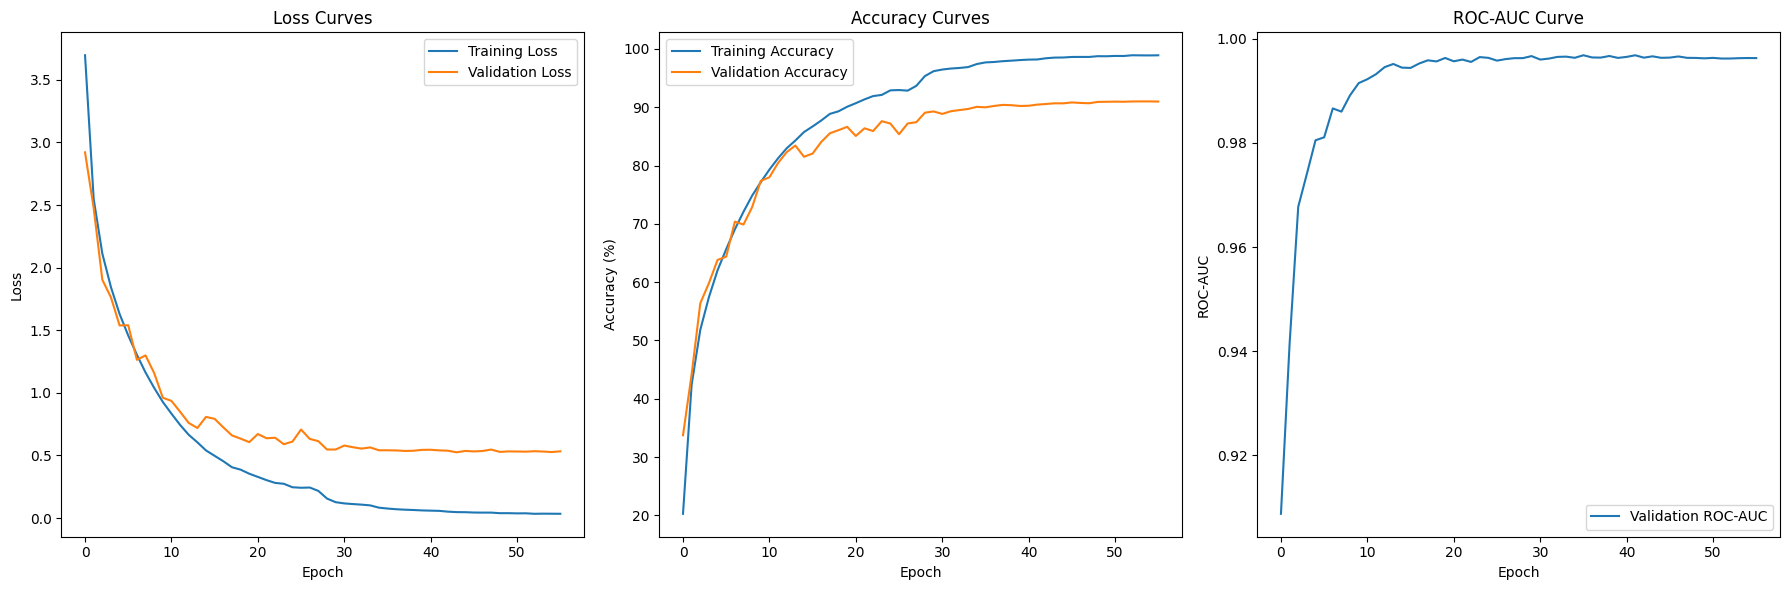

In [13]:
# Visualize training and validation metrics including ROC-AUC
plt.figure(figsize=(18, 6))

# Loss plot
plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

# Accuracy plot
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curves')
plt.legend()

# ROC-AUC plot
plt.subplot(1, 3, 3)
plt.plot(val_aucs, label='Validation ROC-AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC Curve')
plt.legend()

plt.tight_layout()
plt.show()

# Save training history for future reference
history = {
    'train_loss': train_losses,
    'val_loss': val_losses,
    'train_acc': train_accuracies,
    'val_acc': val_accuracies,
    'val_auc': val_aucs
}

# Save training history to file
import json
with open('training_history.json', 'w') as f:
    json.dump({k: [float(val) for val in v] for k, v in history.items()}, f)

## Model Evaluation

Evaluate the model on the validation set with metrics relevant to BirdCLEF

In [14]:
# Load the best model
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.eval()

# Evaluate on validation set
all_predictions = []
all_labels = []
all_probabilities = []

with torch.no_grad():
    for inputs, labels in tqdm(val_loader, desc="Evaluating"):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

        _, predicted = torch.max(outputs, 1)

        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_probabilities.append(probabilities.cpu().numpy())

# Convert to numpy arrays
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)
all_probabilities = np.concatenate(all_probabilities, axis=0)

# Calculate metrics
accuracy = np.mean(all_predictions == all_labels) * 100

# For ROC-AUC we need one-hot encoded labels
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)
labels_onehot = encoder.fit_transform(all_labels.reshape(-1, 1))

# Get numeric class names (for clarity since we're using precomputed features)
class_names = [f"class_{i}" for i in range(num_classes)]

try:
    # Calculate macro average AUC (similar to competition metric)
    roc_auc = roc_auc_score(labels_onehot, all_probabilities, multi_class='ovr', average='macro')
    print(f"Validation Accuracy: {accuracy:.2f}%")
    print(f"Validation ROC-AUC: {roc_auc:.4f}")
except Exception as e:
    print(f"Error calculating ROC-AUC: {e}")
    print(f"Validation Accuracy: {accuracy:.2f}%")

# Print classification report (limited to top 20 classes for readability)
top_classes = 20  # Adjust based on number of classes
report_classes = class_names[:top_classes] if len(class_names) > top_classes else class_names
print("\nClassification Report (Top 20 classes):")
print(classification_report(
    all_labels,
    all_predictions,
    target_names=report_classes,
    labels=range(len(report_classes)),
    zero_division=0
))

Evaluating:   0%|          | 0/1189 [00:00<?, ?it/s]

Error calculating ROC-AUC: index 204 is out of bounds for axis 1 with size 204
Validation Accuracy: 89.99%

Classification Report (Top 20 classes):
              precision    recall  f1-score   support

     class_0       0.33      0.12      0.18         8
     class_1       0.54      0.41      0.47        17
     class_2       1.00      1.00      1.00         3
     class_3       1.00      1.00      1.00         3
     class_4       1.00      0.83      0.91        12
     class_5       1.00      1.00      1.00         5
     class_6       0.98      0.96      0.97        50
     class_7       0.30      0.25      0.27        12
     class_8       0.59      0.68      0.63        28
     class_9       0.50      1.00      0.67         1
    class_10       1.00      1.00      1.00        16
    class_11       0.00      0.00      0.00         0
    class_12       0.98      0.88      0.93        57
    class_13       1.00      1.00      1.00        30
    class_14       0.89      0.97      0.

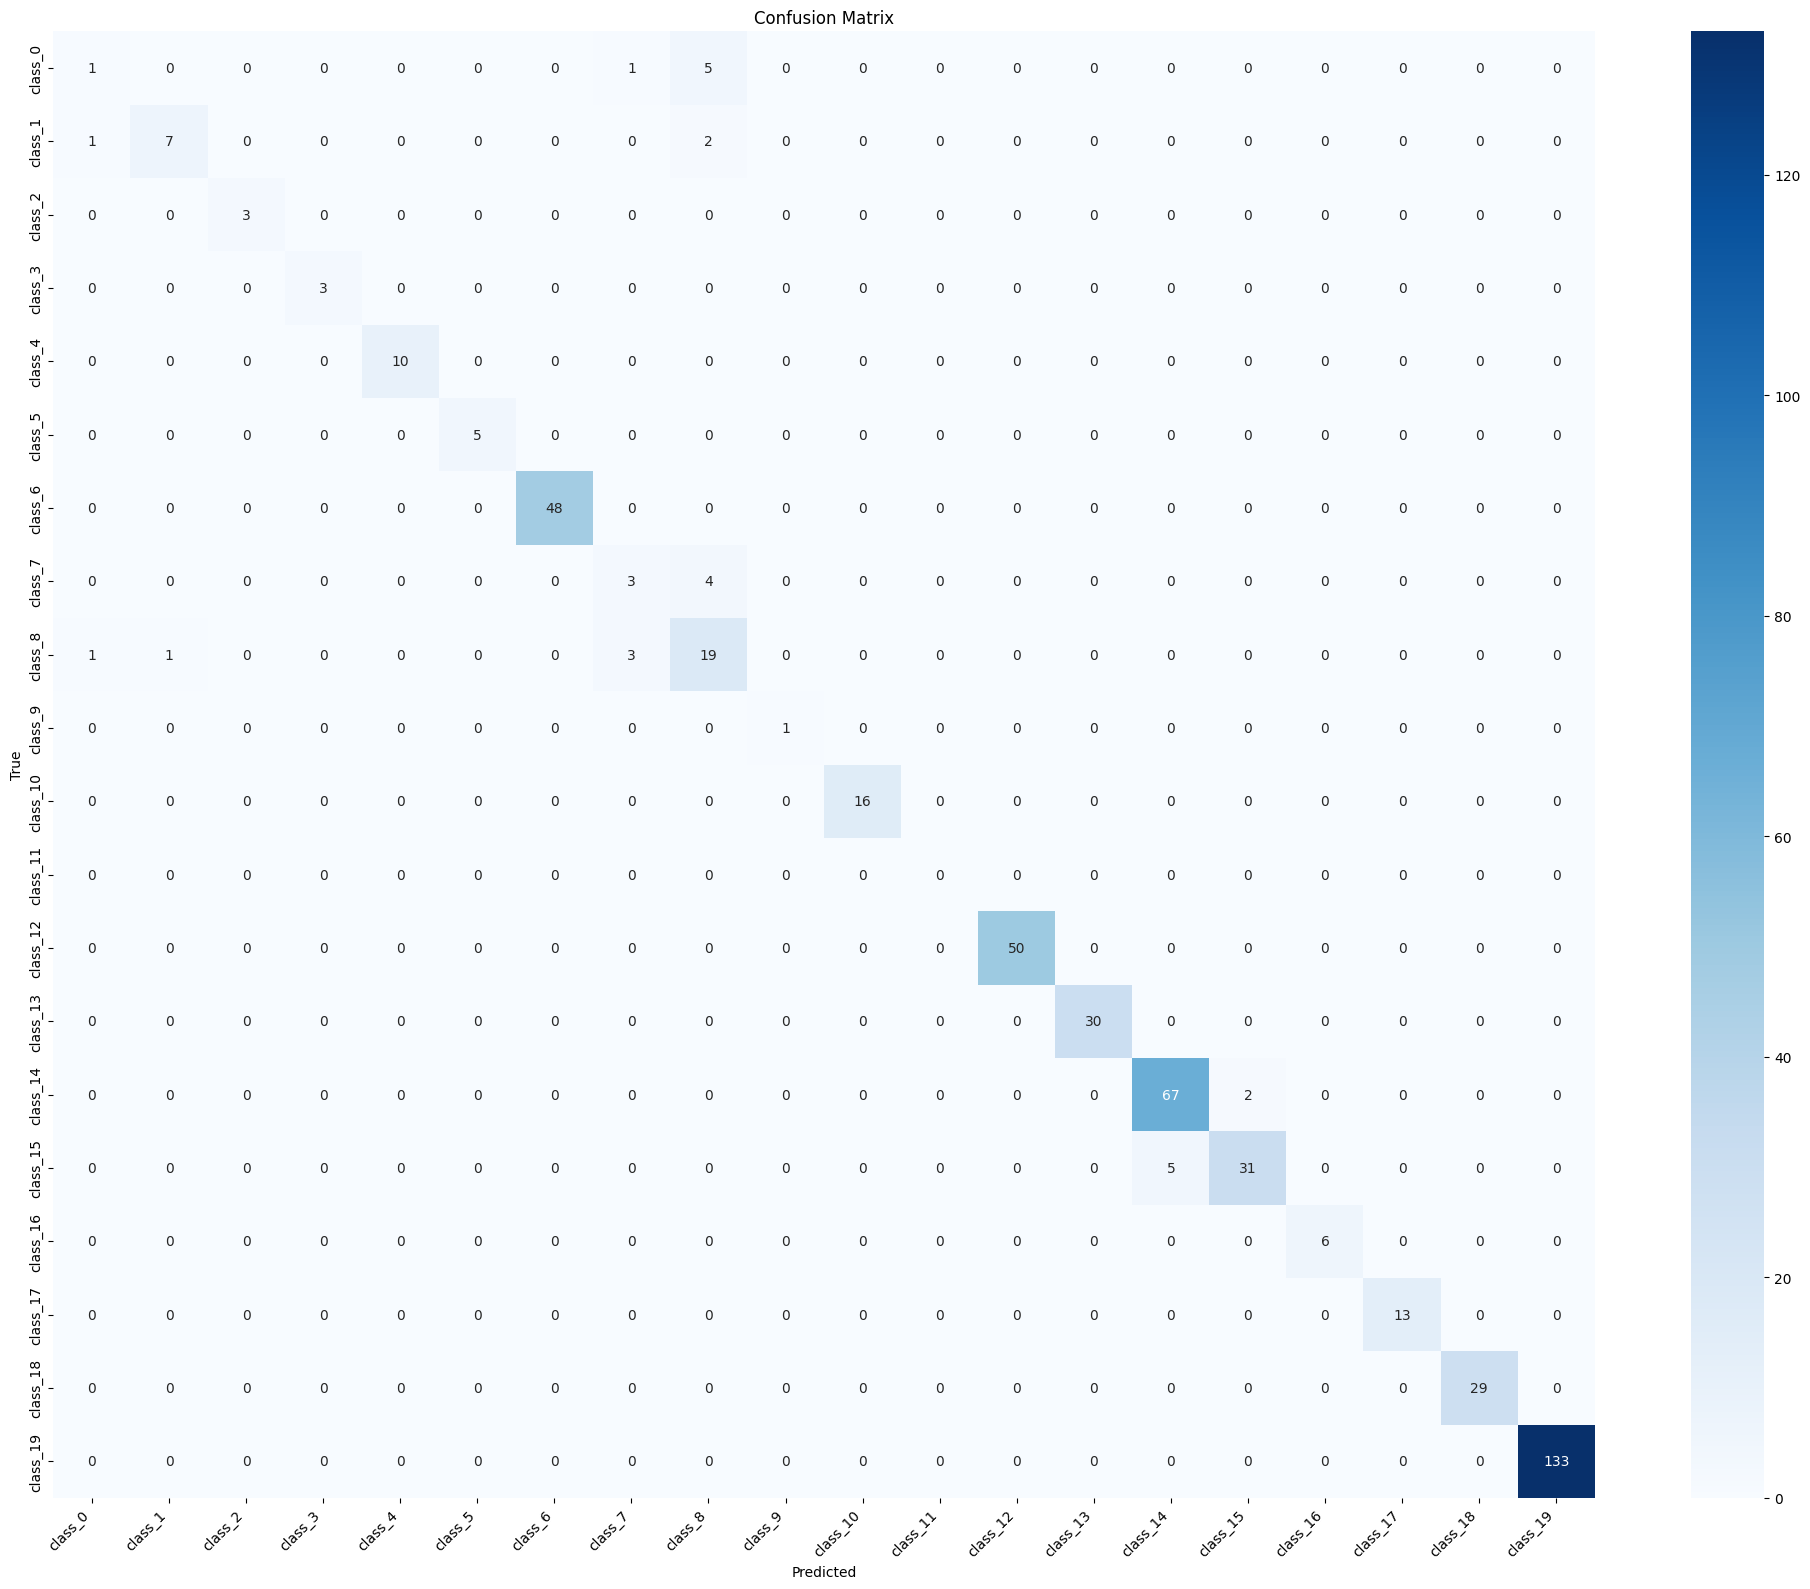

In [15]:
# Confusion Matrix (for top classes)
num_display_classes = min(20, len(class_names))
cm = confusion_matrix(
    all_labels,
    all_predictions,
    labels=range(num_display_classes)
)

plt.figure(figsize=(20, 16))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names[:num_display_classes],
    yticklabels=class_names[:num_display_classes]
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Model Export

Export the model for use in the ensemble

In [16]:
# Bundle everything needed for prediction
export_bundle = {
    'model_state_dict': model.state_dict(),
    'class_mapping': {idx: f"class_{idx}" for idx in range(num_classes)},
    'feature_params': {
        'target_shape': (128, 256),
        'sr': 32000,
        'n_mels': 128,
        'fmin': 500,
        'fmax': 15000,
        'chunk_duration': 5
    },
    'model_architecture': 'BirdCNN-FromScratch',
    'performance': {
        'accuracy': float(accuracy),
        'val_loss': float(min(val_losses)) # Changed from best_val_loss to min(val_losses)
    }
}

torch.save(export_bundle, 'bird_cnn_scratch_better.pth')
print("Model bundle saved to 'bird_cnn_scratch_better.pth'")

Model bundle saved to 'bird_cnn_scratch_better.pth'


In [17]:
class BirdMelFeatureExtractor:
    def __init__(self, target_shape=(128, 256), chunk_duration=5, sr=32000,
                n_mels=128, fmin=20, fmax=16000):
        """
        Initialize the FeatureExtractor for bird audio.

        Parameters:
        - target_shape (tuple): The target shape for resized mel spectrograms (height, width).
        - chunk_duration (int): Duration of each audio chunk in seconds.
        - sr (int): Sample rate
        - n_mels (int): Number of mel bands
        - fmin, fmax (int): Min and max frequency for mel filters
        """
        self.target_shape = target_shape
        self.chunk_duration = chunk_duration
        self.sr = sr
        self.n_mels = n_mels
        self.fmin = fmin
        self.fmax = fmax

    def load_audio(self, file_path):
        """
        Load an audio file and resample to target sr.
        """
        try:
            audio, orig_sr = sf.read(file_path)
            if len(audio.shape) > 1:  # Stereo to mono
                audio = audio.mean(axis=1)
            if orig_sr != self.sr:
                audio = librosa.resample(audio, orig_sr=orig_sr, target_sr=self.sr)
            return audio, self.sr
        except Exception as e:
            print(f"Error loading audio file {file_path}: {e}")
            return None, None

    def compute_melspec(self, audio):
        """
        Compute a mel-spectrogram from an audio signal with normalization.
        """
        # Apply a small offset to avoid log(0)
        melspec = librosa.feature.melspectrogram(
            y=audio,
            sr=self.sr,
            n_mels=self.n_mels,
            fmin=self.fmin,
            fmax=self.fmax
        )

        # Convert to dB scale
        melspec_db = librosa.power_to_db(melspec, ref=np.max)

        # Normalize to [0, 1] range for better training
        melspec_normalized = (melspec_db - melspec_db.min()) / (melspec_db.max() - melspec_db.min() + 1e-8)

        return melspec_normalized

    def extract_features_from_file(self, file_path, label_idx):
        """
        Extract features from a single audio file.
        Returns features and labels for this file.
        """
        data = []
        labels = []

        try:
            # Load the audio file
            audio, sr = self.load_audio(file_path)
            if audio is None:
                return data, labels

            # Find how many full chunks we can extract
            chunk_samples = int(self.chunk_duration * sr)
            num_chunks = max(1, len(audio) // chunk_samples)

            # For very short files, pad the audio
            if len(audio) < chunk_samples:
                audio = np.pad(audio, (0, chunk_samples - len(audio)), mode='constant')
                num_chunks = 1

            # Extract chunks and compute spectrograms
            for i in range(num_chunks):
                start = i * chunk_samples
                end = min(start + chunk_samples, len(audio))

                # Get audio chunk
                chunk = audio[start:end]

                # Check if the chunk is complete
                if len(chunk) < chunk_samples:
                    # Pad short chunks
                    chunk = np.pad(chunk, (0, chunk_samples - len(chunk)), mode='constant')

                # Compute mel spectrogram
                melspec = self.compute_melspec(chunk)

                # Resize to target shape if needed
                if melspec.shape != self.target_shape:
                    # Using simple resize (can be improved with better interpolation)
                    from skimage.transform import resize
                    melspec = resize(melspec, self.target_shape, mode='constant')

                # Add channel dimension for CNN input
                melspec = np.expand_dims(melspec, axis=0)

                # Append results
                data.append(melspec)
                labels.append(label_idx)

        except Exception as e:
            print(f"Error processing {file_path}: {e}")

        return data, labels

## Inference on New Audio

Make predictions on single audio files

In [18]:
def predict_audio(model, audio_path, label_mapping, feature_extractor=None):
    """
    Make a prediction on a single audio file
    """
    model.eval()

    if feature_extractor is None:
        # Create feature extractor with default parameters if not provided
        feature_extractor = BirdMelFeatureExtractor(
            target_shape=(128, 256),
            chunk_duration=5,
            sr=32000,
            n_mels=128,
            fmin=500,
            fmax=15000
        )

    # Extract features
    features, _ = feature_extractor.extract_features_from_file(audio_path, 0)  # Label doesn't matter here

    if not features:
        return "Could not process audio file"

    # Convert to tensor and move to device
    features_tensor = torch.tensor(np.array(features), dtype=torch.float32).to(device)

    with torch.no_grad():
        # Get model predictions
        outputs = model(features_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)

        # Average probabilities across chunks if multiple
        avg_probs = torch.mean(probabilities, dim=0)

        # Get top 5 predictions
        top_probs, top_indices = torch.topk(avg_probs, k=min(5, len(label_mapping)))

        # Format results
        results = [
            (label_mapping[idx.item()], prob.item()) for idx, prob in zip(top_indices, top_probs)
        ]

        return results

# Test on a sample audio file if available
try:
    test_file = os.path.join(AUDIO_DIR, train_df['filename'].iloc[0])
    label_mapping = {idx: f"class_{idx}" for idx in range(num_classes)}

    # Create feature extractor for inference
    inference_extractor = BirdMelFeatureExtractor(
        target_shape=(128, 256),
        chunk_duration=5,
        sr=32000,
        n_mels=128,
        fmin=500,
        fmax=15000
    )

    predictions = predict_audio(
        model,
        test_file,
        label_mapping,
        inference_extractor
    )

    print(f"File: {test_file}")
    print("Top predictions:")
    for bird_class, probability in predictions:
        print(f"{bird_class}: {probability:.4f}")
except Exception as e:
    print(f"Error running inference: {e}")

File: /content/drive/MyDrive/birdclef-2025-data/train_audio/1139490/CSA36385.ogg
Top predictions:
class_0: 0.6453
class_8: 0.2573
class_59: 0.0342
class_1: 0.0290
class_7: 0.0228
